In [1]:
import sys
sys.path.append("./source")

# libraries for this project
from lmmNet import *
import harmonic
import train_onestep
import predict_onestep
import predict_lmmNet

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

# 1. Data Preparation

Here we test our methods on the 2-D Cubic Harmonic Oscillator

$$ \begin{array}
\dot{x_1} & = & -0.1 x_1^3 + 2.0 x_2^3 \\
\dot{x_2} & = & -2.0 x_1^3 - 0.1 x_2^3 \\
\end{array} $$

with the initial conditions $x_1(0) = 2, x_2(0) = 0$. We will use three different approaches:
1. LmmNet
2. One-step machine learning method
3. Recurrent approach

We will also investigate how the method performs under noisy conditions.

In [2]:
time_points, cubic_data = harmonic.simulate_default()

Text(0.5, 1.0, 'Phase Portrait of the 2-D Harmonic Oscillator')

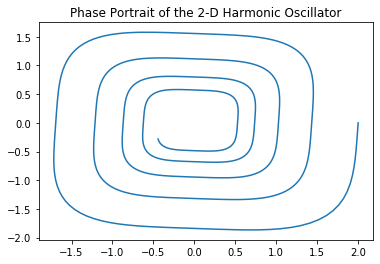

In [3]:
# Phase plane plot
plt.plot(cubic_data[0,:,0], cubic_data[0,:,1])
plt.title('Phase Portrait of the 2-D Harmonic Oscillator')

Now that we have simulated a dataset, let's create a suitable training data and augment it for learning.

In [4]:
# create a pandas dataframe from the tensors

df = pd.DataFrame(cubic_data.numpy()[0])
df.columns = ['x_component', 'y_component']
df['Strain'] = [0] * df.shape[0]
df = df.set_index('Strain')
df['Time'] = time_points
df.head()

,x_component,y_component,Time
Strain,,,
0,2.000000,0.000000,0.00
0,1.992028,-0.159044,0.01
0,1.983873,-0.316164,0.02
0,1.974847,-0.471225,0.03
0,1.963856,-0.623866,0.04


# 2. LmmNet

Next, we train the LmmNet on the tensor data.

In [5]:
# we specify a LMM scheme and number of steps
dt = time_points[1] - time_points[0]
M = 1
scheme = 'AM'
model = lmmNet(dt, cubic_data, M, scheme, hidden_units=256)

N_Iter = 10000
model.train(N_Iter, debug=False)

In [7]:
import predict_lmmNet

x0 = cubic_data[0,0,:] # initial conditions
predicted_traj = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model), x0, time_points)

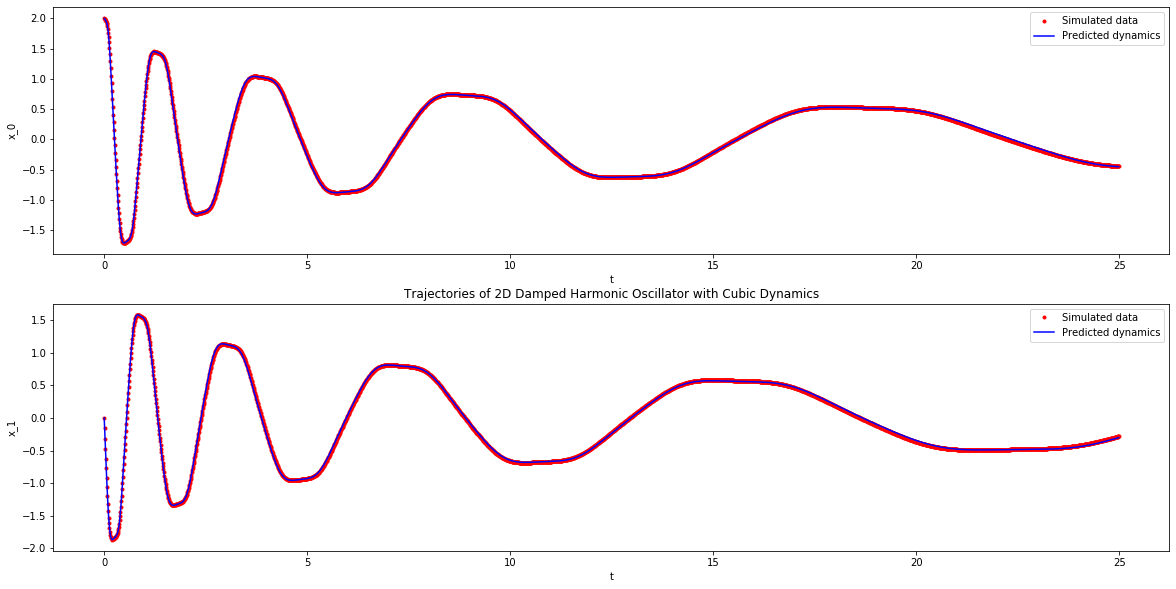

In [10]:
# plot the time-course of the predicted trajectory

plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, cubic_data[0,:, species], 'r.', label='Simulated data')
    plt.plot(time_points, predicted_traj[:,species], 'b-', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('x_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Damped Harmonic Oscillator with Cubic Dynamics')
plt.show()

Text(0.5, 1.0, 'Phase plane of 2D Damped Harmonic Oscillator with Cubic Dynamics')

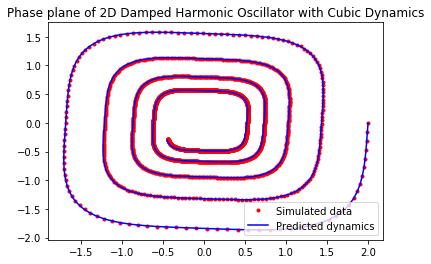

In [11]:
# Phase plane

plt.plot(cubic_data[0,:,0], cubic_data[0,:,1], 'r.', label='Simulated data')
plt.legend()
plt.plot(predicted_traj[:,0], predicted_traj[:,1], 'b-', label='Predicted dynamics')
plt.legend()
plt.title('Phase plane of 2D Damped Harmonic Oscillator with Cubic Dynamics')

# 3. One-step machine learning method

Workflow:
* create and augment training data
* fit model with pairs of derivatives and time-series measurements as features
* make predictions and simulations by numerical integration of the learned model

In [5]:
# now generate and augment the training dataset
print('Original data shape:', df.shape)

feature_list = [] # here we do not have external time-series or control variables
target_list = ['x_component', 'y_component']

df_train = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=2500)
display(df_train)

Original data shape: (2500, 3)


feature      target     feature      target
             x_component x_component y_component y_component
Strain Time                                                 
0      0.00     1.998828   -0.573398    0.000471  -15.997040
       0.01     1.993096   -0.684085   -0.159436  -15.865381
       0.02     1.985152   -0.905458   -0.316710  -15.602062
       0.03     1.974995   -1.059658   -0.471352  -15.371268
       0.04     1.963967   -1.274520   -0.624012  -15.117056
...                  ...         ...         ...         ...
       24.95   -0.441769   -0.039289   -0.288236    0.174894
       24.96   -0.442157   -0.038403   -0.286486    0.175301
       24.97   -0.442537   -0.037522   -0.284731    0.175704
       24.98   -0.442907   -0.036636   -0.282973    0.176112
       24.99   -0.443269   -0.036193   -0.281210    0.176315

[2500 rows x 4 columns]

x_component


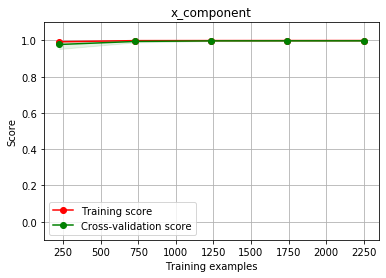

Target: x_component, CV Pearson R2 coefficient: 0.999665
y_component


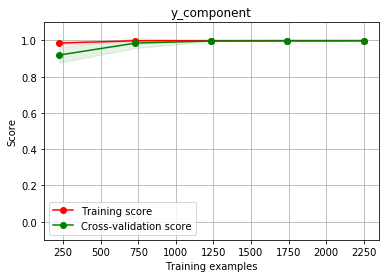

Target: y_component, CV Pearson R2 coefficient: 0.999769
Average training score: 0.9997171935701215


In [6]:
# create a random forest model with 20 estimators
rf_model = RandomForestRegressor(n_estimators=20)
figure_path = './plots/'

# train a model
rf_dict, score_dict = train_onestep.train_classic(df_train, rf_model, plot=True,model_type='random_forest', figure_path=figure_path)

x_component RMSE: -0.0006198750052197476 standard deviation: 0.032565189940815725


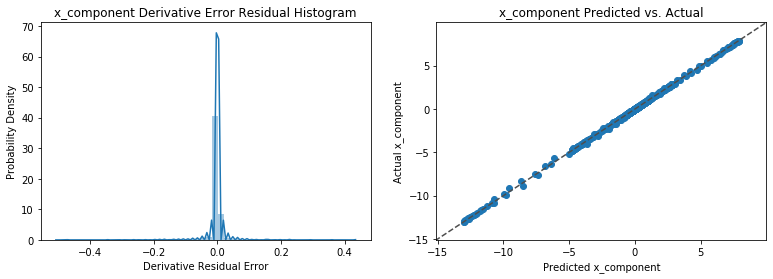

y_component RMSE: -9.99821634344349e-05 standard deviation: 0.027464202931615486


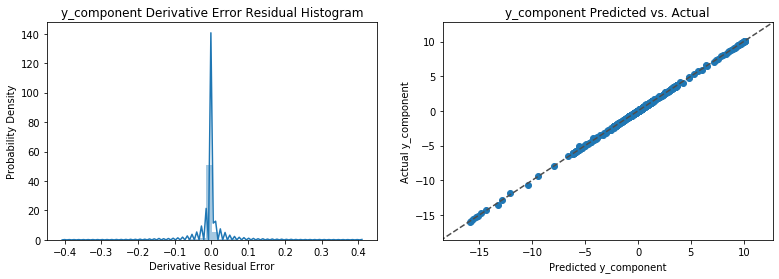

Total Derivative Mean Error: 0.04642612902341366 Error Standard Deviation: 0.07803623073057836


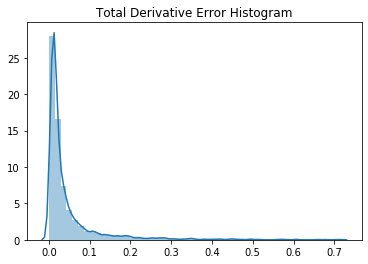

In [7]:
# generate reports on the residual errors

train_onestep.compute_error(df_train,rf_dict,plot=True,model_type='random_forest')

Real data:


,x_component,y_component
Strain,,
0,2.000000,0.000000
0,1.992028,-0.159044
0,1.983873,-0.316164
0,1.974847,-0.471225
0,1.963856,-0.623866
...,...,...
0,-0.441769,-0.288236
0,-0.442157,-0.286486
0,-0.442536,-0.284731


Predicted data:


,x_component,y_component
Time,,
0.00,2.000000,0.000000
0.01,1.994118,-0.158341
0.02,1.987381,-0.315737
0.03,1.979731,-0.471371
0.04,1.971683,-0.624107
...,...,...
24.95,0.415992,0.146020
24.96,0.415854,0.144442
24.97,0.415716,0.142864


./source/predict_onestep.py:216: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:221: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: x_component 5.061218915188388 RMSE percentage: 182.30376808210497
ML Fit: y_component 5.145283472719319 RMSE percentage: 165.7149090493355
ML model aggregate error
Average RMSE: 5.103251193953854
Total percentage error: 174.0093385657202


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


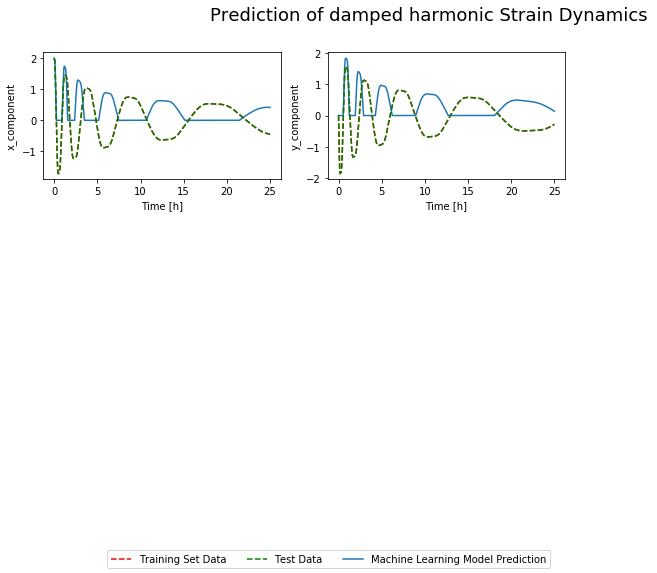

In [8]:
# now we make predictions via numerical integration
# note that in predict_integrate, the function expects a normal dataframe and not the time-series multi-index dataframe
time_points, predictions = predict_onestep.predict_integrate(df, df, rf_dict, target_list, feature_list, title='damped harmonic', plot=True,model_type='random_forest', subplots=(2,1))

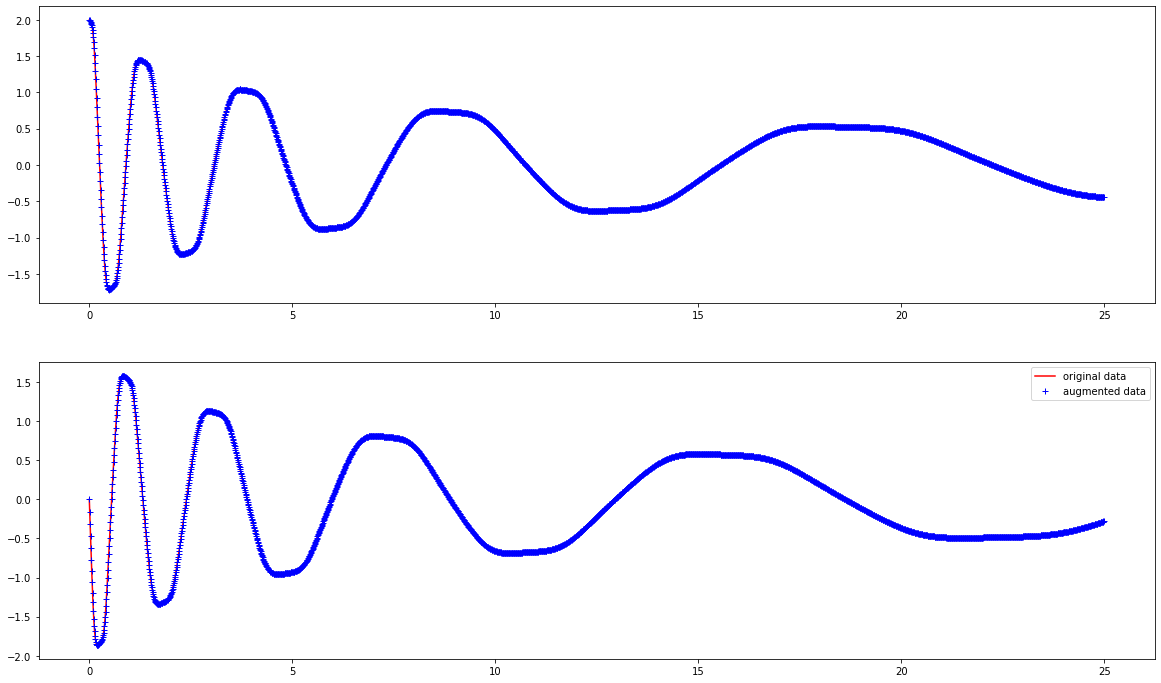

In [9]:
# make sure the augmented data corresponds to the original data
plt.figure(figsize = (20, 12))
for species in range(2):
    plt.subplot(2, 1, species + 1)
    plt.plot(time_points, df.iloc[:,species], 'r-', label='original data')
    plt.plot(time_points, df_train[('feature', df.columns[species])], 'b+', label='augmented data')
    
plt.legend()